# Test of using cygrid with the data

The capability of cygrid when interfacing with the integrated intensity maps is tested here. If it goes well, a self-contained module will be soon created.

In [1]:
import cygrid
from astropy.io import fits
import numpy as np

### Extract Cartesian HDUL for cygrid

For the poor-man's approximation (still **reasonable**), the FITS HDU list contains 4 HDUs for each observing velocity. These sight-lines are aranged as (inner position, inner intensity, outer position, outer intensity), where inner and outer refer to the direction of observation from Earth. These Cartesian positions are converted to galactic coordinates to interface with cygrid.

The results of this test will help for the debugging process for the complete implementation of cygrid (defining beam size and line-of-sight from Earth's position).

In [2]:
hdul = fits.open('history/MilkyWay/r500_n20245/integrated_intensity.fits')

r2d = 180./np.pi
d2r = np.pi/180.

rGal = 18000
rGalEarth = 8178
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    2                                                  
NAXIS2  =                    5                                                  
EXTEND  =                    T                                                  
VELOCITY=                -48.0                                                  
DIREC   = 'Inner disk'                                                          

In [4]:
print(len(hdul), '\n')
for i in np.arange(0, len(hdul), 2):
    if hdul[i+1].data.any(): print(i)

144 

38
42
46
50
54
58
62
66
70
74
78
82
86
90
94
98
102


In [57]:
i = 40

positions = []
intensityMap = []

# Convert the Cartesian map to galactic coordinates for the input to cygrid
tempPositions = hdul[i+0].data
intensityMap = np.array(hdul[i+1].data)
galPosition = [r2d*np.arcsin(tempPositions[:,0]/rGalEarth),
               r2d*np.arctan2(tempPositions[:,1], (np.sqrt(rGal**2-tempPositions[:,0]**2)+np.sqrt(rGalEarth**2-tempPositions[:,0]**2)))]
positions = np.array(galPosition).T

# Convert the Cartesian map to galactic coordinates for the input to cygrid
tempPositions = hdul[i+2].data
intensityMap = np.append(intensityMap, hdul[i+3].data, axis=0)
galPosition = [r2d*np.arcsin(tempPositions[:,0]/rGalEarth),
               r2d*np.arctan2(tempPositions[:,1], (np.sqrt(rGal**2-tempPositions[:,0]**2)-np.sqrt(rGalEarth**2-tempPositions[:,0]**2)))]
galPosition = np.array(galPosition).T
galPosition[galPosition[:,0]>=0,0] = 90 + galPosition[galPosition[:,0]>=0,0][::-1]
galPosition[galPosition[:,0]<0,0] = -90 + galPosition[galPosition[:,0]<0,0][::-1]
positions = np.append(positions, galPosition, axis=0)
hdul[i].header['VELOCITY']

-16.0

## CAREFUL!!

The ``CRPIX`` values need to be the *exact* (float) center of their corresponding ``NAXIS`` values. Otherwise there will be a series of undefined behaviour due to the weights being assigned as zeros.

The values in the header define the datacube that is created. The input data to cygrid is ideally greater than the desired resolution.

The function of the different header keys is summarised below.

  * ``NAXIS`` is the number of axes. The minimum number of dimensions is 3.
  * ``NAXISi`` refers to the size of the *i*th axis. The first axis is for longitude and the second is for lattitude, and they need to be the same length and one-dimensional. The remaining axis is for frequencies observed, and it can be n dimensions.
  * ``CTYPEi`` is typically used for the positional axes, where it defines the type of coordinates used (using the ``astropy`` convention). For this galactic example, these are GLON and GLAT to refer to the galactic longitude and lattitude. For specific observations in the Milky Way, such as PDRs, one can use ``RA`` and ``DEC``.
  * ``CUNITi`` is the units used for the axis, again using the ``astropy`` convention.
  * ``CDELTi`` is the size of the individual pixels in the desired output image (thus i=(1,2)). For an image with map size (l<sub>1</sub>,l<sub>2</sub>), the formula used is ``CDELT1``=``NAXIS1``/l<sub>1</sub> and ``CDELT2``=``NAXIS2``/l<sub>2</sub>.
  * ``CRPIXi`` is the indeces of the center reference pixel in the output image. This should be a float if there is an odd number of pixels in one of the axis (see above).
  * ``CRVALi`` is the value of the center reference pixel. By default, it is (0,0).

In [58]:
mapsize = (360, 15)
axis1size = 100
axis2size = 25

header = {
   'NAXIS': 3,
   'NAXIS1': axis1size,
   'NAXIS2': axis2size,
   'NAXIS3': intensityMap.shape[1],
   'CTYPE1': 'GLON-SFL',
   'CTYPE2': 'GLAT-SFL',
   'CUNIT1': 'deg',
   'CUNIT2': 'deg',
   'CDELT1': mapsize[0]/axis1size,
   'CDELT2': mapsize[1]/axis2size,
   'CRPIX1': axis1size/2.,
   'CRPIX2': axis2size/2.,
   'CRVAL1': 0,
   'CRVAL2': 0,
   }

Initialise the gridder with the header of the desired image.

In [59]:
kernelsize_sigma = 1
kernel_type = 'gauss1d'
kernel_params = (kernelsize_sigma,)
kernel_support = 3*kernelsize_sigma
hpx_maxres = kernelsize_sigma/2

mygridder = cygrid.WcsGrid(header)
mygridder.set_kernel(
  kernel_type,
  kernel_params,
  kernel_support,
  hpx_maxres
  )

In [60]:
mygridder.grid(positions[:,0], positions[:,1], intensityMap, weights=None)
# if not mygridder.get_weights().all(): print('ERROR')

The input data contains only the sight-lines which have an integrated intensity at the corresponding observing velocity, so obtaining the datacube will likely produce a number of NaN values. This is because some of the positions in the output map cannot be inferred from the input data. Usually the input data for ``cygrid`` is oversampled, thus the output image does not have this issue.

While it is not a major issue (some useful data is still contained in the appropriate coordinates), it does need some post-processing before being plotted. A method is still required to correct for this in the KOSMA-tau<sup>3</sup> models.

In [61]:
data = mygridder.get_datacube()

/home/craig/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/craig/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [49]:
gridcy = mygridder.get_world_coords()

The purpose of using the ``get_world_coords`` method of the gridder instance is that it can compare the output coordinates with the input coordinates. This is done below to show that the output image coordinates (in orange) covers encompasses the input coordinates (in blue).

(25, 100)
(356, 25, 100)


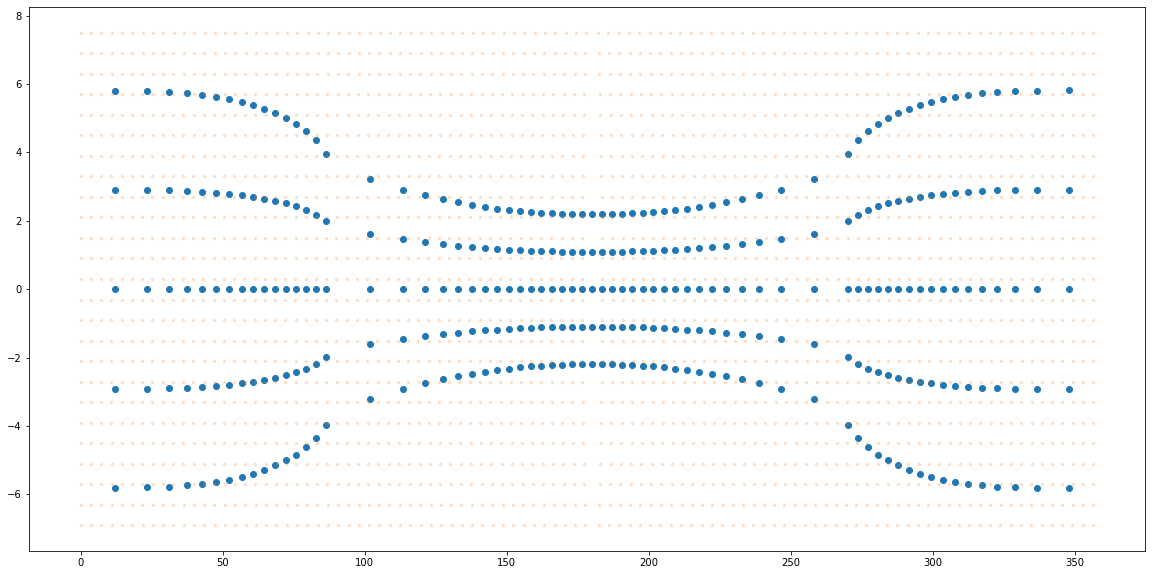

In [18]:
plt.figure(figsize=(20,10))
plt.scatter(positions[:,0]+180, positions[:,1])
non_nan = np.isnan(np.mean(data,axis=0))
print(non_nan.shape)
print(data.shape)
plt.scatter(gridcy[0], gridcy[1], alpha=0.2, s=5)

Finally the image from ``cygrid`` can be plotted. It is of an appropriate resolution that there are ~~no~~ few stripes of undefined pixels. There are still glitches visible in the plot at the top and bottom of the galactic plane, and this is part of the pixelated method that was used to determine these sight-lines.

The next step for the model is to utilise a beam definition to determine the sightlines, then do the same procedure with ``cygrid``. That *should* complete this part of the model. Also it will help remove the errors thrown by the astropy celestial coordinates.

/home/craig/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/coordinate_range.py:74: RuntimeWarning: invalid value encountered in sign
  wjump = wjump + np.sign(wjump) * 180.
/home/craig/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/coordinate_range.py:83: RuntimeWarning: invalid value encountered in sign
  wjump = wjump + np.sign(wjump) * 180.
/home/craig/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/coordinate_range.py:74: RuntimeWarning: invalid value encountered in sign
  wjump = wjump + np.sign(wjump) * 180.
/home/craig/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/coordinate_range.py:83: RuntimeWarning: invalid value encountered in sign
  wjump = wjump + np.sign(wjump) * 180.
/home/craig/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/coordinate_range.py:74: RuntimeWarning: invalid value encountered in sign
  wjump = wjump + np.sign(wjump) * 180.
/home/craig/miniconda3/li

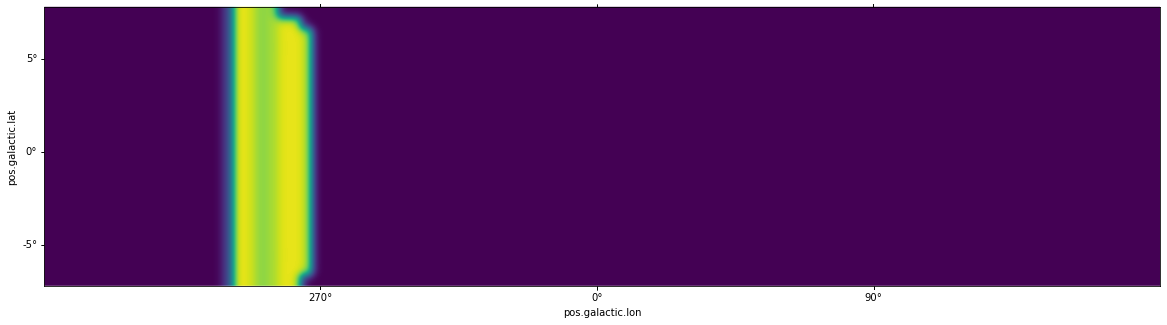

In [73]:
import matplotlib.pyplot as plt
from astropy import wcs

target_wcs = wcs.WCS(header)

fig = plt.figure(figsize=(20,40))
ax = fig.add_subplot(111, projection=target_wcs.celestial)
ax.imshow(np.nan_to_num(data[60,:,:]), origin='lower', interpolation='gaussian')